# Bias-Variance Tradeoff - Lab

## Introduction

In this lab, you'll practice the concepts you learned in the last lesson, bias-variance tradeoff. 

## Objectives

In this lab you will: 

- Demonstrate the tradeoff between bias and variance by way of fitting a machine learning model 

## Let's get started!

In this lab, you'll try to predict some movie revenues based on certain factors, such as ratings and movie year. Start by running the following cell which imports all the necessary functions and the dataset: 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

df = pd.read_excel('movie_data_detailed_with_ols.xlsx')
print(df.columns)
print(df.nunique())
df.head()

Index(['Unnamed: 0', 'budget', 'domgross', 'title', 'Response_Json', 'Year',
       'imdbRating', 'Metascore', 'imdbVotes', 'Model'],
      dtype='object')
Unnamed: 0       30
budget           26
domgross         30
title            30
Response_Json     1
Year              6
imdbRating       20
Metascore        22
imdbVotes        27
Model            30
dtype: int64


,Unnamed: 0,budget,domgross,title,Response_Json,Year,imdbRating,Metascore,imdbVotes,Model
0,0,13000000,25682380,21 &amp; Over,0,2008,6.8,48,206513,4.912759e+07
1,1,45658735,13414714,Dredd 3D,0,2012,0.0,0,0,2.267265e+05
2,2,20000000,53107035,12 Years a Slave,0,2013,8.1,96,537525,1.626624e+08
3,3,61000000,75612460,2 Guns,0,2013,6.7,55,173726,7.723381e+07
4,4,40000000,95020213,42,0,2013,7.5,62,74170,4.151958e+07


Subset the `df` DataFrame to only keep the `'domgross'`, `'budget'`, `'imdbRating'`, `'Metascore'`, and `'imdbVotes'` columns. 

In [2]:
# Subset the DataFrame
sel_lst = ['domgross','budget','imdbRating','Metascore','imdbVotes']
sub_df = df.loc[:,sel_lst]
print(sub_df.columns)
print(sub_df.nunique())
sub_df.head()

Index(['domgross', 'budget', 'imdbRating', 'Metascore', 'imdbVotes'], dtype='object')
domgross      30
budget        26
imdbRating    20
Metascore     22
imdbVotes     27
dtype: int64


,domgross,budget,imdbRating,Metascore,imdbVotes
0,25682380,13000000,6.8,48,206513
1,13414714,45658735,0.0,0,0
2,53107035,20000000,8.1,96,537525
3,75612460,61000000,6.7,55,173726
4,95020213,40000000,7.5,62,74170


## Split the data


- First, assign the predictors to `X` and the outcome variable, `'domgross'` to `y` 
- Split the data into training and test sets. Set the seed to 42 and the `test_size` to 0.25 

In [3]:
# domgross is the outcome variable
X = sub_df.drop('domgross', axis=1)
y = sub_df['domgross']

print('X:',X.columns)

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X: Index(['budget', 'imdbRating', 'Metascore', 'imdbVotes'], dtype='object')


In [4]:
X_train.columns

Index(['budget', 'imdbRating', 'Metascore', 'imdbVotes'], dtype='object')

Use the `MinMaxScaler` to scale the training set. Remember you can fit and transform in a single method using `.fit_transform()`.  

In [5]:
# Transform with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

Transform the test data (`X_test`) using the same `scaler`:  

In [6]:
# Scale the test set
X_test_scaled = scaler.transform(X_test)

## Fit a regression model to the training data

In [7]:
# Your code 
linreg = LinearRegression()
reg_scaled = linreg.fit(X_train_scaled, y_train)

Use the model to make predictions on both the training and test sets: 

In [8]:
# Training set predictions
lm_train_predictions = reg_scaled.predict(X_train_scaled)
#lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = reg_scaled.predict(X_test_scaled)
#lm_test_predictions = linreg.predict(X_test_scaled)

Plot predictions for the training set against the actual data: 

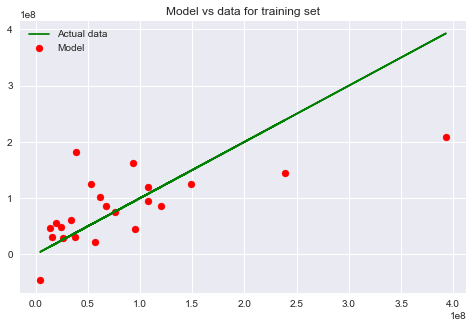

In [9]:
# Run this cell - vertical distance between the points and the line denote the errors
plt.figure(figsize=(8, 5))
plt.scatter(y_train, lm_train_predictions, color='red', label='Model')
plt.plot(y_train, y_train, color='green', label='Actual data')
plt.title('Model vs data for training set')
plt.legend();

Plot predictions for the test set against the actual data: 

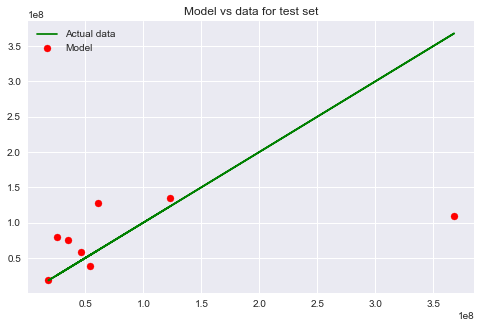

In [10]:
# Run this cell - vertical distance between the points and the line denote the errors
plt.figure(figsize=(8, 5))
plt.scatter(y_test, lm_test_predictions, color='red', label='Model')
plt.plot(y_test, y_test, color='green', label='Actual data')
plt.title('Model vs data for test set')
plt.legend();

## Bias

Create a function `bias()` to calculate the bias of a model's predictions given the actual data: $Bias(\hat{f}(x)) = E[\hat{f}(x)-f(x)]$   
(The expected value can simply be taken as the mean or average value.)  

In [11]:
import numpy as np
def bias(y, y_hat):
    return np.mean(y_hat - y)

## Variance
Create a function `variance()` to calculate the variance of a model's predictions: $Var(\hat{f}(x)) = E[\hat{f}(x)^2] - \big(E[\hat{f}(x)]\big)^2$

In [12]:
def variance(y_hat):
    return np.mean(np.multiply(y_hat,y_hat)) - np.mean(y_hat)**2

## Calculate bias and variance

In [13]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions)
v = variance(lm_train_predictions)
print('Train bias: {} \nTrain variance: {}'.format(b, v))

# Train bias: -8.127906105735085e-09 
# Train variance: 3406811040986517.0

Train bias: -2.573836933482777e-08 
Train variance: 3406811040986514.0


In [14]:
# Bias and variance for test set 
b = bias(y_test, lm_test_predictions)
v = variance(lm_test_predictions)
print('Test bias: {} \nTest variance: {}'.format(b, v))

# Test bias: -10982393.918069275 
# Test variance: 1518678846127932.0

Test bias: -10982393.918069294 
Test variance: 1518678846127934.0


## Overfit a new model 

Use `PolynomialFeatures` with degree 3 and transform `X_train_scaled` and `X_test_scaled`. 

**Important note:** By including this, you don't only take polynomials of single variables, but you also combine variables, eg:

$ \text{Budget} * \text{MetaScore} ^ 2 $

What you're essentially doing is taking interactions and creating polynomials at the same time! Have a look at how many columns we get using `np.shape()`! 


In [15]:
np.shape(X_train_scaled)

(22, 4)

In [16]:
np.shape(X_test_scaled)

(8, 4)

In [17]:
# Your code here
poly = PolynomialFeatures(3)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [18]:
# Check the shape
np.shape(X_train_poly)

(22, 35)

In [19]:
np.shape(X_test_poly)

(8, 35)

In [20]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3
0,0.202733,0.765432,0.541667,0.141391
1,0.034169,0.839506,0.500000,0.384192
2,0.157175,0.925926,0.645833,0.137984
3,0.330296,0.790123,0.614583,0.139785
4,1.000000,0.777778,0.291667,0.239554


In [21]:
pd.DataFrame(X_train_poly).head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.0,0.202733,0.765432,0.541667,0.141391,0.041101,0.155179,0.109814,0.028665,0.585886,...,0.448456,0.317355,0.082839,0.224580,0.058622,0.015302,0.158927,0.041484,0.010829,0.002827
1,1.0,0.034169,0.839506,0.500000,0.384192,0.001167,0.028685,0.017084,0.013127,0.704771,...,0.591659,0.352385,0.270767,0.209877,0.161266,0.123914,0.125000,0.096048,0.073802,0.056708
2,1.0,0.157175,0.925926,0.645833,0.137984,0.024704,0.145533,0.101509,0.021688,0.857339,...,0.793832,0.553698,0.118299,0.386204,0.082514,0.017629,0.269378,0.057553,0.012296,0.002627
3,1.0,0.330296,0.790123,0.614583,0.139785,0.109096,0.260975,0.202994,0.046170,0.624295,...,0.493270,0.383681,0.087267,0.298440,0.067879,0.015439,0.232136,0.052799,0.012009,0.002731
4,1.0,1.000000,0.777778,0.291667,0.239554,1.000000,0.777778,0.291667,0.239554,0.604938,...,0.470508,0.176440,0.144915,0.066165,0.054343,0.044633,0.024812,0.020379,0.016738,0.013747


Fit a regression model to the training data: 

In [22]:
# Your code here
polyreg = LinearRegression()
polyreg.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Use the model to make predictions on both the training and test sets: 

In [23]:
# Training set predictions
poly_train_predictions = polyreg.predict(X_train_poly)

# Test set predictions 
poly_test_predictions = polyreg.predict(X_test_poly)

Plot predictions for the training set against the actual data: 

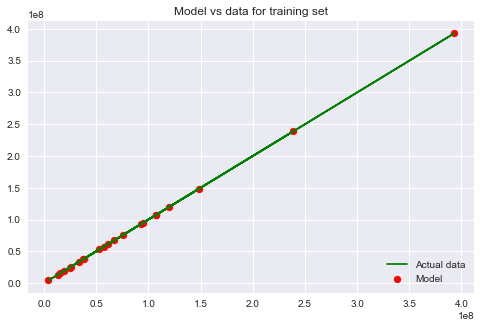

In [24]:
# Run this cell - vertical distance between the points and the line denote the errors
plt.figure(figsize=(8, 5))
plt.scatter(y_train, poly_train_predictions, color='red', label='Model')
plt.plot(y_train, y_train, color='green', label='Actual data')
plt.title('Model vs data for training set')
plt.legend(loc=4);

Plot predictions for the test set against the actual data: 

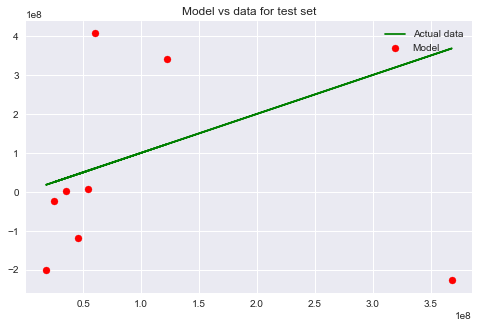

In [25]:
# Run this cell - vertical distance between the points and the line denote the errors
plt.figure(figsize=(8, 5))
plt.scatter(y_test, poly_test_predictions, color='red', label='Model')
plt.plot(y_test, y_test, color='green', label='Actual data')
plt.title('Model vs data for test set')
plt.legend(loc=1);

Calculate the bias and variance for the training set: 

In [26]:
# Bias and variance for training set 
b = bias(y_train, poly_train_predictions)
v = variance(poly_train_predictions)
print('Train bias: {} \nTrain variance: {}'.format(b, v))

# Train bias: 3.5898251966996625e-07 
# Train variance: 7394168636697528.0

Train bias: 1.8748370083895596e-06 
Train variance: 7394168636697507.0


Calculate the bias and variance for the test set: 

In [27]:
# Bias and variance for test set 
b = bias(y_test, poly_test_predictions)
v = variance(poly_test_predictions)
print('Test bias: {} \nTest variance: {}'.format(b, v))

# Test bias: -68166032.47666144 
# Test variance: 4.798244829435879e+16

Test bias: -68166032.47665997 
Test variance: 4.798244829435956e+16


## Interpret the overfit model

In [28]:
# Your description here
# The training predictions from the second model perfectly match the actual data points - which indicates overfitting.  
# The bias and variance for the test set both increased drastically for this overfit model.

## Level Up (Optional)

In this lab we went from 4 predictors to 35 by adding polynomials and interactions, using `PolynomialFeatures`. That being said, where 35 leads to overfitting, there are probably ways to improve by adding just a few polynomials. Feel free to experiment and see how bias and variance improve!

## Summary

This lab gave you insight into how bias and variance change for a training and a test set by using both simple and complex models. 